# Double seasonality in the *La Permanence* dataset

This notebook investigates the seasonality in the *La Permanence* dataset (see `la_permanence_EDA.ipynb` for a preliminary look at the dataset).  In fact, we expect seasonality of *multiplicity 2*, i.e. 24-hour as well as 7-day seasonality.  

Before invoking more powerful tools, we will first follow a naive approach, which can take the following two forms:
1. perform a **24-hour** seasonal decomposition on the data, for which we expect to observe 7-day seasonality in the resulting *trend*, and then perform a **7-day** seasonal decomposition on this trend;
1. perform a **7-day** seasonal decomposition on the data, which will eliminate the 7-day seasonality but miss the seasonality at the finer 24-hour timescale, and then perform a **24-hour** seosonal decomposition on the *seasonal* component.  

Since we will be using *additive* decompositions, there is no point in performing further seasonal decomposition on the resulting seasonal or trend components.  

**Remarks.**
1. For simplicity we will work on the *rue du Fer à Moulin* dataset.
1. The dataset is currently relatively small, and thus the results obtained should be taken with a grain of salt.
1. *This is work in progress!*

## Imports

In [1]:
import datetime
import os
import pytz
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

## Constants

In [2]:
tz_utc = pytz.timezone("UTC")  # timestamp of data is in UTC standard
tz_paris = pytz.timezone("Europe/Paris")  # coworking spaces are in Pairs, France

days_of_the_week = {0: 'Mo', 1: 'Tu', 2: 'We', 3: 'Th', 4: 'Fr', 5: 'Sa', 6: 'Su'}

nb_minutes = 10
RULE = f'{nb_minutes}T' # resampling rule: resolution of time regularization
FREQ = RULE
HOUR = 60//nb_minutes
DAY = 24*HOUR
WEEK = 7*DAY
SEASONALITY = DAY

In [11]:
??sm.tsa.seasonal_decompose

## Helper functions

In [12]:
def seasonalDecomposition(data, freq, model='additive'):
    """Customized plot of seasonal decomposition.
    
    Parameters
    ----------
    data: dataframe
    freq: seasonality
    
    Returns
    -------
    seasonal_decomposition: an object with seasonal, trend, and resid attributes
    axes: a tuple with the four axes in the plot
    """
    seasonal_decomposition = sm.tsa.seasonal_decompose(data.dropna(), model=model, freq=freq)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,8), sharex=True);
    
    seasonal_decomposition.resid.plot(ax=ax1);
    seasonal_decomposition.seasonal.plot(ax=ax2);
    seasonal_decomposition.trend.plot(ax=ax3);
    data.plot(ax=ax4, color='#ff7f0e');
    
    ax1.set_ylabel("Residual")
    ax2.set_ylabel("Seasonal")
    ax3.set_ylabel("Trend")
    ax4.set_ylabel("Data")
    
    ax4.axes.get_xaxis().label.set_visible(False);
    ts_min = data.index.min()
    ts_max = data.index.max()
    availability_date_range = pd.date_range(ts_min.date(), ts_max.date());
    ax4.set_xticks(availability_date_range);
    
    ax4.set_xticklabels([pd.to_datetime(x).strftime("%A %d %b")
                         if x.weekday() in [0]
                         else pd.to_datetime(x).strftime("%a")
                         for x in availability_date_range])
    ax4.tick_params(axis='x', labelrotation=60)
        
    for ax in [ax1, ax2, ax3, ax4]:
        ax.legend().remove()
        ax.grid()
    axes = (ax1, ax2, ax3, ax4)
    return seasonal_decomposition, axes


## Data
The dataset is saved in a `csv` file located in `~/Projects/la_permanence/attendance.csv`.

In [4]:
%%time
filename = 'attendance.csv'
foldername = 'Projects/la_permanence'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)
filesize = os.path.getsize(filepath)
if filesize > 1e6:
    print("Size of data file: {}MB.".format(filesize//1000000))
elif filesize > 1e3:
    print("Size of data file: {}KB.".format(filesize//1000))
else:
    print("Size of data file: {}B.".format(filesize))
print("Loading data...")
raw_data = pd.read_csv(filepath, sep=',')
print("Shape of dataframe: {0}.".format(raw_data.shape))

Size of data file: 426KB.
Loading data...
Shape of dataframe: (16490, 3).
CPU times: user 12.3 ms, sys: 3.19 ms, total: 15.5 ms
Wall time: 13.6 ms


In [5]:
availability = raw_data.copy()

availability['timestamp'] = availability['timestamp'].apply(
    lambda s: pd.Timestamp(
        *tuple(map(int, s.split("-")))
    )
)
availability['timestamp'] = availability['timestamp'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_paris))
availability.set_index("timestamp", inplace=True)
availability = availability.resample(RULE).mean().interpolate()

We will work on the data for the two locations separately, beginning with *rue du Fer à Moulin*:

In [6]:
moulin = availability.loc[:, ['Moulin']].copy()
moulin.columns = ['seats']
alesia = availability.loc[:, ['Alésia']].copy()
alesia.columns = ['seats']

## Aternative 1: 24-hour seasonal decomposition followed by 7-day seasonal decomposition

Following alternative 1, we begin with a **24-hour** seasonal decomposition on the observed data.

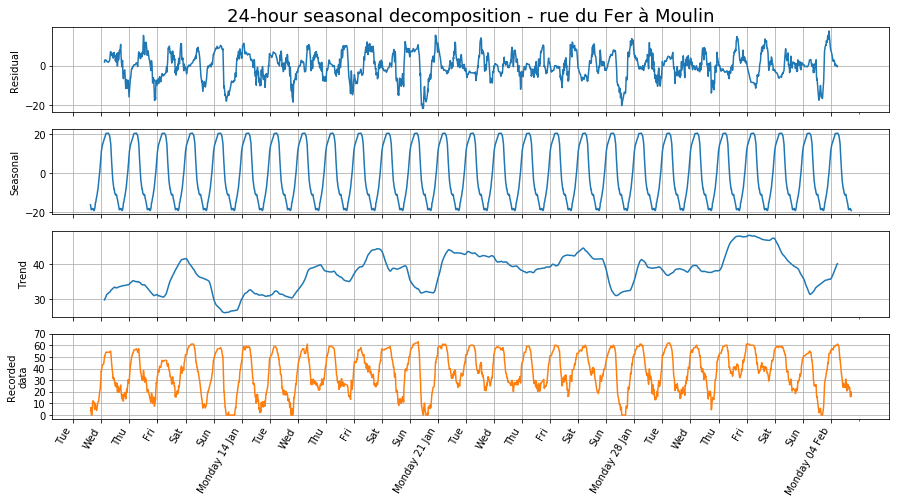

In [7]:
moulin_day_decomposition, axes = seasonalDecomposition(moulin, freq=DAY)
ax1, _, _, ax4 = axes
ax1.set_title("24-hour seasonal decomposition - rue du Fer à Moulin", fontsize=18);
ax4.set_yticks(range(0, 80, 10))
ax4.set_ylabel("Recorded\ndata");

We observe **7-day** seasonality in the *trend* as anticipated.

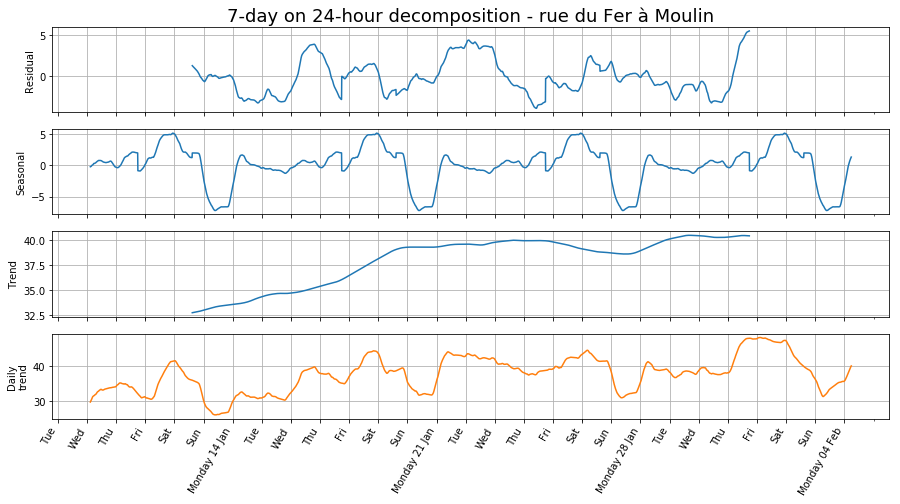

In [8]:
moulin_day_week_decomposition, axes = seasonalDecomposition(moulin_day_decomposition.trend, freq=WEEK)
ax1, ax2, ax3, ax4 = axes
ax1.set_title("7-day on 24-hour decomposition - rue du Fer à Moulin", fontsize=18);
ax4.set_ylabel("Daily\ntrend");

The *seasonal* composition does not appear to have any seasonality (other than 7-day).  We could try to perform a 24-hour seasonal decomposition, just to see what happens, but we have probably done enough in this first naive approach.

## Alternative 2: 7-day seasonal decomposition followed by 24-hour seasonal decomposition

Following alternative 2, we begin with a **7-day** seasonal decomposition of the original, obserbed data.

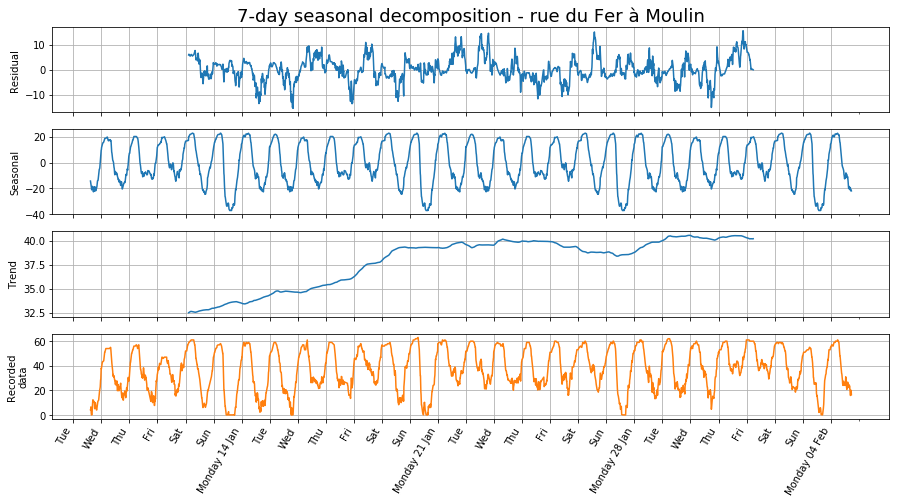

In [9]:
# moulin_week_decomposition = sm.tsa.seasonal_decompose(moulin, model='additive', freq=WEEK)
moulin_week_decomposition, axes = seasonalDecomposition(moulin, freq=WEEK)
ax1, ax2, ax3, ax4 = axes
ax1.set_title("7-day seasonal decomposition - rue du Fer à Moulin", fontsize=18);
ax4.set_ylabel("Recorded\ndata");

The *trend* is no longer seasonal itself, and appears to be slowly increasing.  On the other hand, we see that the *seasonal* component exhibits **24-hour** seasonality (superposed to its exact 7-day periodicity).  This was expected: the 7-day decomposition is not equipped to capture the 24-hour seasonalty oberved in the original data.

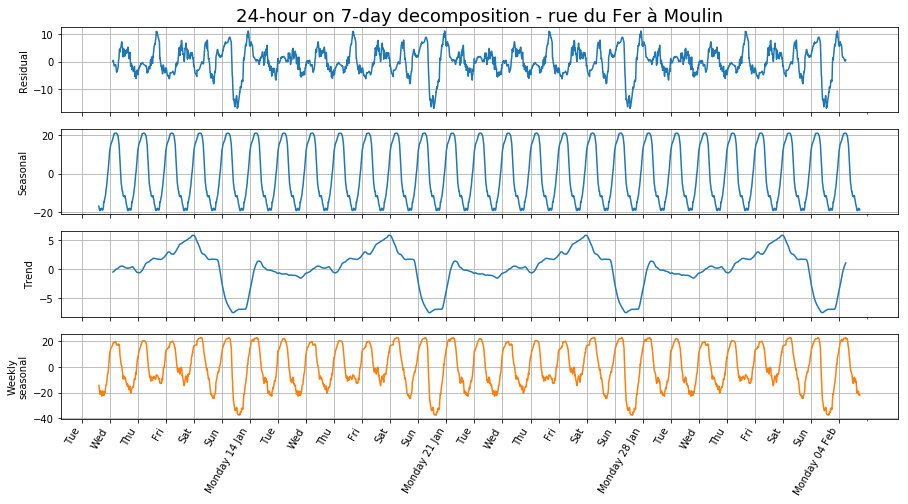

In [10]:
# moulin_week_day_decomposition = sm.tsa.seasonal_decompose(moulin_week_decomposition.seasonal, model='additive', freq=DAY)
moulin_week_day_decomposition, axes = seasonalDecomposition(moulin_week_decomposition.seasonal, freq=DAY)
ax1, ax2, ax3, ax4 = axes
ax1.set_title("24-hour on 7-day decomposition - rue du Fer à Moulin", fontsize=18);
ax4.set_ylabel("Weekly\nseasonal");

Since:
1. the data to which this 24-hour decomposition is applied had exact 7-day periodicity;
1. 7 days is a multiple of 24 hours; and
1. the decomposition is additive;  

we conclude that the three components (trend, seasonal, residual) just obtained are all 7-day periodic. Therefore, a further decomposition will not do anything.